# Introduction
- We consider a simple two layer MLP ![](/Twolayer_mlp.png)
- Suppose z_0 is already a probabilistic input, a RV with distribution p(z_0) and w_0 and w_1 are Gaussian Weight distributions from a multivariate Gaussian, the activation function f is ReLU
- We get the chained system function $$ net(z_0|w_0,w_1)=p(z_2) = ReLU(w_1 \cdot ReLU(w_0 \cdot z_0)) $$
- The task of computing the transformed density is generally hard
- We want to perform moment matching with the help of the *Law of the unconscious statistician* $$ E\left\{g(x)\right\} = \int_{- \infty}^{+ \infty} g(x)f_X(x)dx $$ where f_X is the density of the RV x
	- Losely spoken: If we know the distribution of the untransformed RV, we can compute the transformed density through a weighted average (because the integrated density is 1)
	- **We can compute this integral by (quasi)- monte carlo sampling**
- This can be applied to our case as well

## Application
- The goal here is a comparison between using intermediate approximations and not using intermediate approximations
- **Version A: No Intermediate**
	- With LOTUS $$ E\left\{z_2\right\} = \int_{-\infty}^{+\infty}ReLU(w_1 \cdot ReLU(w_0 \cdot z_0))\cdot p(z_0) dz_0 $$
- **Version B: Intermediate**
	- With LOTUS $$ E\left\{z_2\right\} = \int_{-\infty}^{+\infty}ReLU(w_1 \cdot z_1) \cdot p(z_1) dz_1 $$
	- p(z_1) is obtained from a similar function and a Gaussian Approximation in the first two moments
- The procedure to compute the terms works with a sample-based Approximation of the integral

# Implementation
- Following, we implement the topic in python with sample based computation
- First, import some libraries

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import mixture
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "12"  # Limit the number of threads used by joblib, windows 11 stuff

- Define some helping functions. 
- **Here, we can choose between ReLU and LeakyReLU!**

In [70]:
#******Define Functions******
def relu(x):
    #eturn ReLU
    #return np.maximum(0, x)
    alpha = 0.05  # Slope for negative values
    return np.where(x > 0, x, alpha * x)

def net_func(z_0, w_0, w_1):
    # Compute the elementwise output of the whole network
    return relu(w_1*relu(z_0*w_0))

def net_func_single(z,w):
    # Compute the Elementwise output of the first layer of the network
    return relu(w*z)


- Generate samples from the input distribution (Gaussian)

In [71]:
num_samples = 100000

# Generate Input Samples from a Gaussian Distribution
z_0_mean = 5
z_0_var = 1
z_0_samples = np.random.normal(z_0_mean, np.sqrt(z_0_var), num_samples)

- The multiplication of random variables is executed here by generating equally many samples as for the input and just elementwise multiply the realizations


In [72]:
# Generate weight samples from a multivariate Gaussian Distribution with definable covariance
mean_vector = [-0.2, 0.5]               # Mean for w_0 and w_1
cov_matrix = [[1, 0.00], [0.00, 1]]     # Covariance matrix for w_0 and w_1

w_samples = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples)
w_0_samples = w_samples[:, 0]  # Extract w_0 samples
w_1_samples = w_samples[:, 1]  # Extract w_1 samples


- First, compute an intermediate (z_1) to compare later

In [73]:
# Compute the output of the first layer of the network (sample based)
z_1 = net_func_single(z_0_samples, w_0_samples)
z_1_mean = np.mean(z_1)
z_1_var = np.var(z_1)


- Then, compute the **direct** approximation of the output

In [74]:
# Compute the direct sampled output of the whole network (propagate through Network Function)
z_2_direct = net_func(z_0_samples, w_0_samples, w_1_samples)
z_2_mean = np.mean(z_2_direct)
z_2_var = np.var(z_2_direct)

- Based on the intermediate z_1 from before, sample newly from a Gaussian with the corresponding moments

In [75]:
#Generate Samples from the first two moments of the intermediate
z_1_gaussian = np.random.normal(z_1_mean, np.sqrt(z_1_var), num_samples)

- Compute the output of the net based on the intermediate Approximation step

In [76]:
# Compute the output of the second layer of the network using the intermediate samples
z_2_intermed = net_func_single(z_1_gaussian, w_1_samples)
z_2_intermed_mean = np.mean(z_2_intermed)
z_2_intermed_var = np.var(z_2_intermed)

- Compare the predictive moments of both distributions

In [77]:
# Compare the moments of z_2_direct and z_2_intermed
print("Comparison of Moments:")
print(f"z_2_direct Mean: {z_2_mean:.4f}, Variance: {z_2_var:.4f}")
print(f"z_2_intermed Mean: {z_2_intermed_mean:.4f}, Variance: {z_2_intermed_var:.4f}")


Comparison of Moments:
z_2_direct Mean: 1.0799, Variance: 8.6053
z_2_intermed Mean: 1.4039, Variance: 6.4561


- Make some graphics (**careful**, these are just KDEs, can be misleading)

Text(0.5, 0.98, 'Moment Matching in Neural Networks')

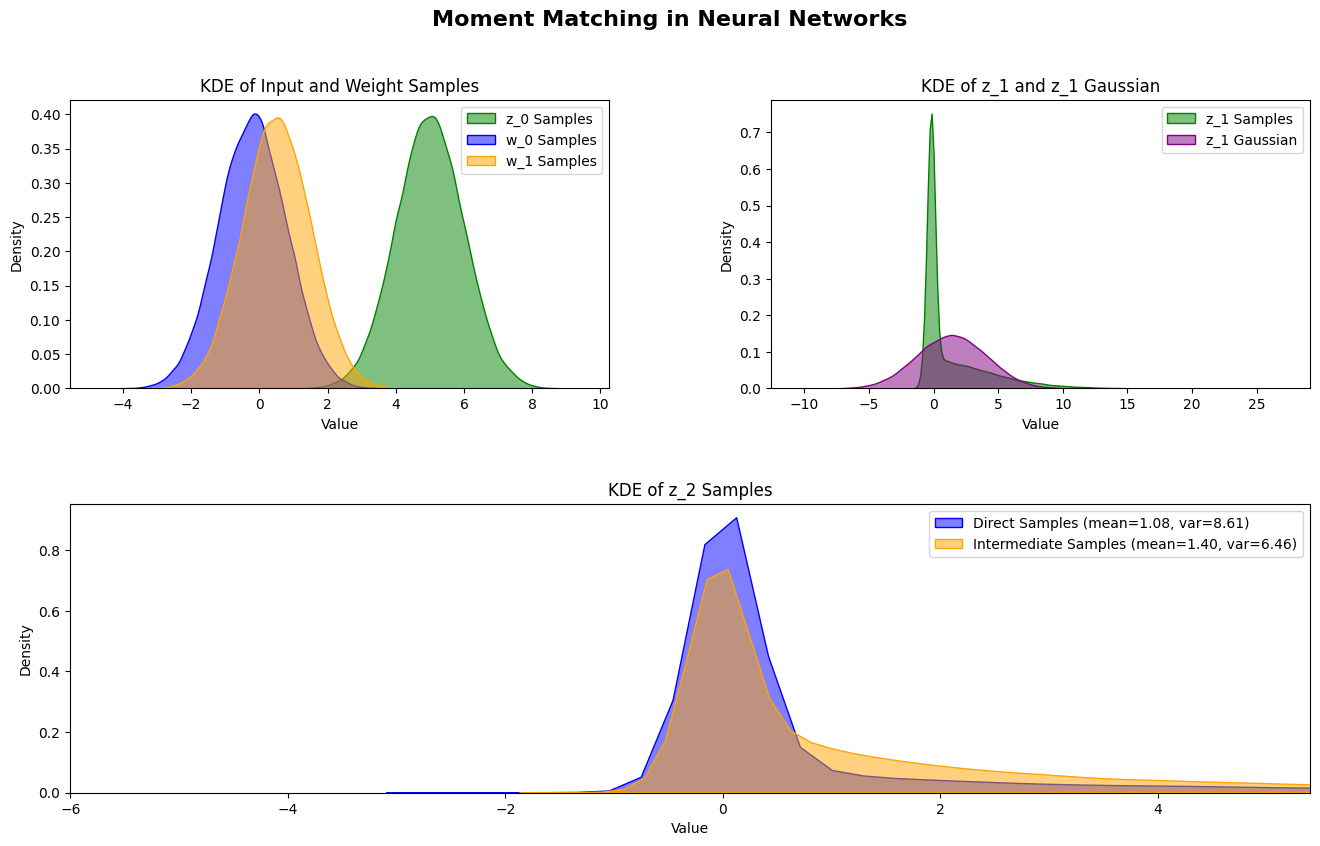

In [78]:
# Create a figure with a custom grid layout
fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3)

# First tile: KDEs of input and weight samples
bw_factor = 1
bw_factor_two = 1
ax1 = fig.add_subplot(grid[0, 0])
sns.kdeplot(z_0_samples, label="z_0 Samples", color="green", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
sns.kdeplot(w_0_samples, label="w_0 Samples", color="blue", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
sns.kdeplot(w_1_samples, label="w_1 Samples", color="orange", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
ax1.set_title("KDE of Input and Weight Samples")
ax1.set_xlabel("Value")
ax1.set_ylabel("Density")
ax1.legend()

# Second tile: KDEs of z_1 and z_1 Gaussian
ax2 = fig.add_subplot(grid[0, 1])
sns.kdeplot(z_1, label="z_1 Samples", color="green", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax2)
sns.kdeplot(z_1_gaussian, label="z_1 Gaussian", color="purple", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax2)
ax2.set_title("KDE of z_1 and z_1 Gaussian")
ax2.set_xlabel("Value")
ax2.set_ylabel("Density")
ax2.legend()

# Third tile: KDEs of z_2 direct and intermediate samples (spanning two columns)
ax3 = fig.add_subplot(grid[1, :])
sns.kdeplot(z_2_direct, label=f"Direct Samples (mean={z_2_mean:.2f}, var={z_2_var:.2f})", color="blue", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax3)
sns.kdeplot(z_2_intermed, label=f"Intermediate Samples (mean={z_2_intermed_mean:.2f}, var={z_2_intermed_var:.2f})", color="orange", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax3)
ax3.set_xlim(left=None, right=5 * z_2_direct.mean())
ax3.set_title("KDE of z_2 Samples")
ax3.set_xlabel("Value")
ax3.set_ylabel("Density")
ax3.legend()

# Add a suptitle and apply tight layout
fig.suptitle("Moment Matching in Neural Networks", fontsize=16,  fontweight='bold')


## Gaussian Mixture Reduction
- In the next step, instead of "just" approximating z_1_intermed with a single Gaussian, we employ a Gaussian Mixture 
- The number of Gaussians in the mixture is a parameter (we start with 2)
- A Scikit-Learn package based on Expectation Maximization is used

In [79]:
gm_components = 2
covariance_type = "full" 
gm = mixture.GaussianMixture(n_components=gm_components, covariance_type=covariance_type)
gm.fit(z_1.reshape(-1, 1))
print("Gaussian Mixture Parameters:")
print(f"Weights: {gm.weights_}")
print(f"Means: {gm.means_.flatten()}")
print(f"Covariances: {gm.covariances_.flatten()}")

Gaussian Mixture Parameters:
Weights: [0.57375015 0.42624985]
Means: [-0.19371708  3.53764353]
Covariances: [0.02637156 9.26870999]


- Draw Samples from the Gaussian Mixture (these are random samples)

In [80]:
z_1_gm = gm.sample(num_samples)
z_1_gm= z_1_gm[0].squeeze()  #Raw result is a tuple, first entry contains the samples

- Compute z_2 based on the new intermediate z1_gm

In [81]:
# Compute the output of the second layer of the network using the intermediate samples
z_2_intermed_gm = net_func_single(z_1_gm, w_1_samples)
z_2_intermed_gm_mean = np.mean(z_2_intermed_gm)
z_2_intermed_gm_var = np.var(z_2_intermed_gm)

- Compare the results of all three versions

In [82]:
# Compare the moments of z_2_direct and z_2_intermed
print("Comparison of Moments:")
print(f"z_2_direct Mean: {z_2_mean:.4f}, Variance: {z_2_var:.4f}")
print(f"z_2_intermed Mean: {z_2_intermed_mean:.4f}, Variance: {z_2_intermed_var:.4f}")
print(f"z_2_intermed GM Mean: {z_2_intermed_gm_mean:.4f}, Variance: {z_2_intermed_gm_var:.4f}")

Comparison of Moments:
z_2_direct Mean: 1.0799, Variance: 8.6053
z_2_intermed Mean: 1.4039, Variance: 6.4561
z_2_intermed GM Mean: 1.1249, Variance: 8.3727


- Plot the comparison of all variants

Text(0.5, 0.98, 'Moment Matching in Neural Networks')

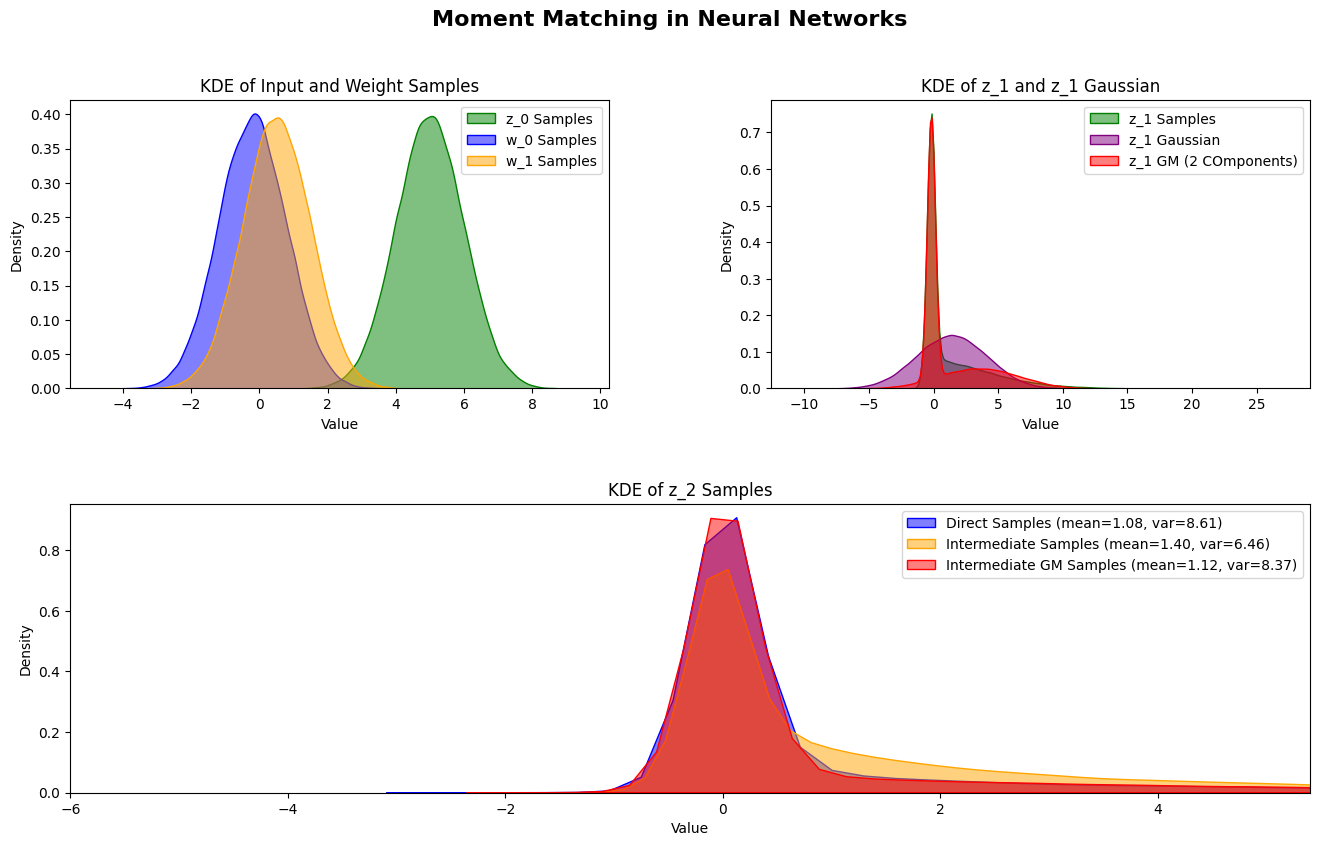

In [ ]:
# Create a figure with a custom grid layout
fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.3)

# First tile: KDEs of input and weight samples
bw_factor = 1
bw_factor_two = 1
ax1 = fig.add_subplot(grid[0, 0])
sns.kdeplot(z_0_samples, label="z_0 Samples", color="green", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
sns.kdeplot(w_0_samples, label="w_0 Samples", color="blue", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
sns.kdeplot(w_1_samples, label="w_1 Samples", color="orange", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax1)
ax1.set_title("KDE of Input and Weight Samples")
ax1.set_xlabel("Value")
ax1.set_ylabel("Density")
ax1.legend()

# Second tile: KDEs of z_1 and z_1 Gaussian
ax2 = fig.add_subplot(grid[0, 1])
sns.kdeplot(z_1, label="z_1 Samples", color="green", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax2)
sns.kdeplot(z_1_gaussian, label="z_1 Gaussian", color="purple", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax2)
sns.kdeplot(z_1_gm, label="z_1 GM (2 Components)", color="red", bw_adjust=bw_factor, fill=True, alpha=0.5, ax=ax2)
ax2.set_title("KDE of z_1 and z_1 Gaussian")
ax2.set_xlabel("Value")
ax2.set_ylabel("Density")
ax2.legend()

# Third tile: KDEs of z_2 direct and intermediate samples (spanning two columns)
ax3 = fig.add_subplot(grid[1, :])
sns.kdeplot(z_2_direct, label=f"Direct Samples (mean={z_2_mean:.2f}, var={z_2_var:.2f})", color="blue", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax3)
sns.kdeplot(z_2_intermed, label=f"Intermediate Samples (mean={z_2_intermed_mean:.2f}, var={z_2_intermed_var:.2f})", color="orange", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax3)
sns.kdeplot(z_2_intermed_gm, label=f"Intermediate GM Samples (mean={z_2_intermed_gm_mean:.2f}, var={z_2_intermed_gm_var:.2f})", color="red", bw_adjust=bw_factor_two, fill=True, alpha=0.5, ax=ax3)
ax3.set_xlim(left=None, right=5 * z_2_direct.mean())
ax3.set_title("KDE of z_2 Samples")
ax3.set_xlabel("Value")
ax3.set_ylabel("Density")
ax3.legend()

# Add a suptitle and apply tight layout
fig.suptitle("Moment Matching in Neural Networks", fontsize=16,  fontweight='bold')
